In [ ]:
%pylab inline

## Working with Hyperboloid

In [121]:
"""Hyperboloid manifold."""

import torch

from manifolds.base import Manifold
from utils.math_utils import arcosh, cosh, sinh 


class Hyperboloid():
    """
    Hyperboloid manifold class.

    We use the following convention: -x0^2 + x1^2 + ... + xd^2 = -K

    c = 1 / K is the hyperbolic curvature. 
    """

    def __init__(self):
        super(Hyperboloid, self).__init__()
        self.name = 'Hyperboloid'
        self.eps = {torch.float32: 1e-7, torch.float64: 1e-15}
        self.min_norm = 1e-15
        self.max_norm = 1e6

    def minkowski_dot(self, x, y, keepdim=True):
        #print(x.shape, y.shape)
        res = torch.sum(x * y, dim=-1) - 2 * x[..., 0] * y[..., 0]
        if keepdim:
            res = res.view(res.shape + (1,))
        return res
    
    def inner(self, p, c, x, y=None, keepdim=True):
        #print(x.shape, y.shape)
        if y == None:
            y = x
        res = torch.sum(x * y, dim=-1) - 2 * x[..., 0] * y[..., 0]
        if keepdim:
            res = res.view(res.shape + (1,))
        return res

    def minkowski_norm(self, u, keepdim=True):
        dot = self.minkowski_dot(u, u, keepdim=keepdim)
        return torch.sqrt(torch.clamp(dot, min=self.eps[u.dtype]))

    def sqdist(self, x, y, c):
        K = 1. / c
        prod = self.minkowski_dot(x, y)
        theta = torch.clamp(-prod / K, min=1.0 + self.eps[x.dtype])
        sqdist = K * arcosh(theta) ** 2
        # clamp distance to avoid nans in Fermi-Dirac decoder
        return torch.clamp(sqdist, max=50.0)

    def proj(self, x, c):
        K = 1. / c
        d = x.size(-1) - 1
        y = x.narrow(-1, 1, d)

        y_sqnorm = torch.norm(y, p=2, dim=1, keepdim=True) ** 2 
        mask = torch.ones_like(x)
        mask[:, 0] = 0
        vals = torch.zeros_like(x)
        vals[:, 0:1] = torch.sqrt(torch.clamp(K + y_sqnorm, min=self.eps[x.dtype]))
        return vals + mask * x

    def proj_tan(self, u, x, c):
        K = 1. / c
        d = x.size(1) - 1
        ux = torch.sum(x.narrow(-1, 1, d) * u.narrow(-1, 1, d), dim=1, keepdim=True)
        mask = torch.ones_like(u)
        mask[:, 0] = 0
        vals = torch.zeros_like(u)
        vals[:, 0:1] = ux / torch.clamp(x[:, 0:1], min=self.eps[x.dtype])
        return vals + mask * u

    def proj_tan0(self, u, c):
        narrowed = u.narrow(-1, 0, 1)
        vals = torch.zeros_like(u)
        vals[:, 0:1] = narrowed
        return u - vals

    def expmap(self, u, x, c, verbose=False):
        if verbose:
            print(f'####### EXPMAP #######')
            print(f'Input: {torch.isnan(u).sum().item()} nans')
        
        K = 1. / c
        sqrtK = K ** 0.5
        normu = self.minkowski_norm(u)
        normu = torch.clamp(normu, max=self.max_norm)
        theta = normu / sqrtK
        theta = torch.clamp(theta, min=self.min_norm)
        result = cosh(theta) * x + sinh(theta) * u / theta
        if verbose:
            print(f'{(theta == 0).sum().item()} zeros in denominator')
        if verbose:      
            print(f'theta: {torch.isnan(theta).sum().item()}, \
                  cosh: {torch.isnan(cosh(theta)).sum().item()}, \
                  sinh: {torch.isnan(sinh(theta)).sum().item()}')

            print(f'Before proj: {torch.isnan(result).sum().item()} nans')
        out = self.proj(result, c)
        if verbose:
            print(f'Output: {torch.isnan(out).sum().item()} nans')
            print(f'$$$$$$ EXPMAP END $$$$$$')
        return out
      
    def logmap(self, x, y, c, verbose=False):
        if verbose:
            print(f'####### LOGMAP #######')
            print(f'Input: {torch.isnan(x).sum().item()} nans')
        K = 1. / c
        xy = torch.clamp(self.minkowski_dot(x, y) + K, max=-self.eps[x.dtype]) - K
        u = y + xy * x * c
        normu = self.minkowski_norm(u)
        normu = torch.clamp(normu, min=self.min_norm)
        dist = self.sqdist(x, y, c) ** 0.5
        result = dist * u / normu
        if verbose:
            print(f'Before proj: {torch.isnan(result).sum().item()} nans')
        out = self.proj_tan(result, x, c)
        if verbose:
            print(f'Output: {torch.isnan(out).sum().item()} nans')
            print(f'$$$$$$ LOGMAP END $$$$$$')
        
        return out

    def expmap0(self, u, c, verbose=False):
        if verbose:
            print(f'####### EXPMAP0 #######')
            print(f'Input: {torch.isnan(u).sum().item()} nans')
        K = 1. / c
        sqrtK = K ** 0.5
        d = u.size(-1) - 1
        x = u.narrow(-1, 1, d).view(-1, d)
        x_norm = torch.norm(x, p=2, dim=1, keepdim=True)
        x_norm = torch.clamp(x_norm, min=self.min_norm)
        theta = x_norm / sqrtK
        res = torch.ones_like(u)
        res[:, 0:1] = sqrtK * cosh(theta)
        res[:, 1:] = sqrtK * sinh(theta) * x / x_norm
        if verbose:
            print(f'max theta is: {torch.max(theta)}, sinh: {torch.max(sinh(theta))}, cosh: {torch.max(cosh(theta))}')
            print(f'res[0:1]: {torch.isnan(res[:, 0:1]).sum().item()} nans')
            print(f'res[1:]: {torch.isnan(res[:, 1:]).sum().item()} nans')
            print(f'x: {torch.isnan(x).sum().item()}, x/x_norm: {torch.isnan(x / x_norm).sum().item()}')
        out = self.proj(res, c)
        
        if verbose:
            print(f'zeros in denominator {(x_norm == 0).sum().item()}')
            print(f'theta: {torch.isnan(theta).sum().item()}, cosh: {torch.isnan(cosh(theta)).sum().item()}, sinh: {torch.isnan(sinh(theta)).sum().item()}')
            print(f'Before proj: {torch.isnan(res).sum().item()} nans')
            
        if verbose:
            print(f'Output: {torch.isnan(out).sum().item()} nans')
            print(f'$$$$$$ EXPMAP0 END $$$$$$')

        return out

    def logmap0(self, x, c, desc=None, verbose=False):
        if verbose:
            print(f'####### LOGMAP0 #######')
            print(f'Input: {torch.isnan(x).sum().item()} nans')
        
        K = 1. / c
        sqrtK = K ** 0.5
        d = x.size(-1) - 1
        y = x.narrow(-1, 1, d).view(-1, d)
        y_norm = torch.norm(y, p=2, dim=1, keepdim=True)
        y_norm = torch.clamp(y_norm, min=self.min_norm)
        res = torch.zeros_like(x)
        if len(x.shape) > 1:
            theta = torch.clamp(x[:, 0:1] / sqrtK, min=1.0 + self.eps[x.dtype])
            res[:, 1:] = sqrtK * arcosh(theta) * y / y_norm
        else:
            theta = torch.clamp(x[0:1] / sqrtK, min=1.0 + self.eps[x.dtype])
            res[1:] = sqrtK * arcosh(theta) * y / y_norm
        if verbose:      
            print(f'zeros in denominator {(y_norm == 0).sum().item()}')      
            print(f'theta: {torch.isnan(theta).sum().item()}, \
                  arcosh: {torch.isnan(arcosh(theta)).sum().item()}')      
            print(f'Output: {torch.isnan(res).sum().item()} nans')
            print(f'$$$$$$ LOGMAP0 END $$$$$$')
        
        
        return res

    def mobius_add(self, x, y, c):
        u = self.logmap0(y, c)
        v = self.ptransp0(x, u, c)
        return self.expmap(v, x, c)

    def mobius_matvec(self, m, x, c, desc=None, verbose=False):   
        if verbose:
            print(f'################ MOBIUS MATVEC #################')
            print(f'Input: {torch.isnan(x).sum().item()} nans')
        u = self.logmap0(x, c)
        if verbose:
            print(f'After logmap0: {torch.isnan(u).sum().item()} nans')
            print(f'u shape: {u.shape}, w^T shape: {m.transpose(-1, -2).shape}')
        
        mu = u @ m.transpose(-1, -2)
        if verbose:
            print(f'After mu: {torch.isnan(mu).sum().item()} nans')
        out = self.expmap0(mu, c)
        if verbose:
            print(f'After expmap0: {torch.isnan(out).sum().item()} nans')
            print(f'$$$$$$$$$$$$$$$$ MOBIUS MATVEC END $$$$$$$$$$$$$$$$$$')
        return out

    def ptransp(self, x, y, u, c):
        logxy = self.logmap(x, y, c)
        logyx = self.logmap(y, x, c)
        sqdist = torch.clamp(self.sqdist(x, y, c), min=self.min_norm)
        alpha = self.minkowski_dot(logxy, u) / sqdist
        res = u - alpha * (logxy + logyx)
        return self.proj_tan(res, y, c)

    def ptransp0(self, x, u, c):
        K = 1. / c
        sqrtK = K ** 0.5
        x0 = x.narrow(-1, 0, 1)
        d = x.size(-1) - 1
        y = x.narrow(-1, 1, d)
        y_norm = torch.clamp(torch.norm(y, p=2, dim=1, keepdim=True), min=self.min_norm)
        y_normalized = y / y_norm
        v = torch.ones_like(x)
        v[:, 0:1] = - y_norm 
        v[:, 1:] = (sqrtK - x0) * y_normalized
        if len(u.shape) > 1:
            alpha = torch.sum(y_normalized * u[:, 1:], dim=1, keepdim=True) / sqrtK
        else:
            alpha = torch.sum(y_normalized * u[1:], dim=1, keepdim=True) / sqrtK
        res = u - alpha * v
        return self.proj_tan(res, x, c)

    def to_poincare(self, x, c, verbose=False):
        if verbose:
            print(f'####### TO POINCARE #######')
            print(f'Input: {torch.isnan(x).sum().item()} nans')
        K = 1. / c
        sqrtK = K ** 0.5
        d = x.size(-1) - 1
        out = sqrtK * x.narrow(-1, 1, d) / (x[:, 0:1] + sqrtK)
        if verbose:
            print((x[:, 0:1] + sqrtK == 0).sum().item())
            print(f'Input: {torch.isnan(out).sum().item()} nans')
            print(f'$$$$$$$ TO POINCARE END $$$$$$$')
        return out

    def to_hyperboloid(self, x, c, verbose=False):
        if verbose:
            print(f'####### TO HYPERBOLOID #######')
            print(f'Input: {torch.isnan(x).sum().item()} nans')
        K = 1./ c
        sqrtK = K ** 0.5
        sqnorm = torch.norm(x, p=2, dim=1, keepdim=True) ** 2
        out = sqrtK * torch.cat([K + sqnorm, 2 * sqrtK * x], dim=1) / (K - sqnorm)
        
        if verbose:
            print(f'Zeros in denominator: {(K - sqnorm == 0).sum().item()}')
            print(f'Output: {torch.isnan(out).sum().item()} nans')
            print(f'$$$$$$$ TO HYPERBOLOID END $$$$$$$')
        
        return out

    def egrad2rgrad(self, p, dp, c):
        K = 1. / c
        sqrtK = K ** 0.5
        u = dp
        x = p
        u.narrow(-1, 0, 1).mul_(-1 / sqrtK)
        u.addcmul_(self.minkowski_dot(x, u, keepdim=True).expand_as(x), x)
        
        return u

In [119]:
# second bad
hyp.minkowski_dot(a_exp, a_exp)

tensor([[-0.9999],
        [ 0.0000]])

In [61]:
# both bad
hyp.minkowski_norm(hyp.proj(a_exp, 2))

tensor([[0.0003],
        [0.0003]])

In [63]:
a_proj = hyp.proj_tan0(a, 2)
a_exp = hyp.expmap0(a_proj, 2)
a_exp

tensor([[5.7936e+01, 3.2135e+01, 4.8202e+01],
        [1.6254e+05, 1.0578e+05, 1.2341e+05]])

In [67]:
# second bad
hyp.minkowski_dot(a_exp, a_exp)

tensor([[-0.4995],
        [ 0.0000]])

In [248]:
def determine_critical_norm(dim, c):
    hyp = Hyperboloid()
    K = -1. / c
    vec = torch.ones(dim).unsqueeze(0).float() / np.sqrt(dim)
    norms = np.arange(start=0, stop=10, step=0.01)
    count_bad = 0
    critical_norm = 10
    for norm in norms:
        vec_scaled = norm * vec
        exp = hyp.expmap0(vec_scaled, c)
        dot = hyp.minkowski_dot(exp, exp)
        if dot > 0.95 * K or dot < 1.05 * K:
            count_bad += 1
        else:
            count_bad = 0
            critical_norm = norm
        
        if count_bad == 5:
            return critical_norm
        
    return 10

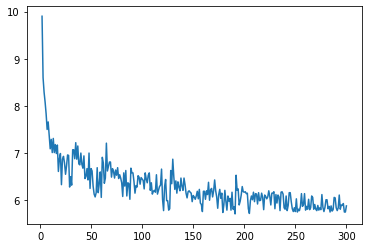

In [260]:
dims = np.arange(2, 301)
norms_1 = np.zeros_like(dims).astype(float)
norms_2 = np.zeros_like(dims).astype(float)
norms_5 = np.zeros_like(dims).astype(float)
norms_7 = np.zeros_like(dims).astype(float)
norms_10 = np.zeros_like(dims).astype(float)
norms_20 = np.zeros_like(dims).astype(float)

for i, dim in enumerate(dims):
    norms_1[i] = determine_critical_norm(dim, 1)
    norms_2[i] = determine_critical_norm(dim, 2)
    norms_5[i] = determine_critical_norm(dim, 5)
    norms_7[i] = determine_critical_norm(dim, 7)
    norms_10[i] = determine_critical_norm(dim, 10)
    norms_20[i] = determine_critical_norm(dim, 20)

plt.plot(dims, norms_1)

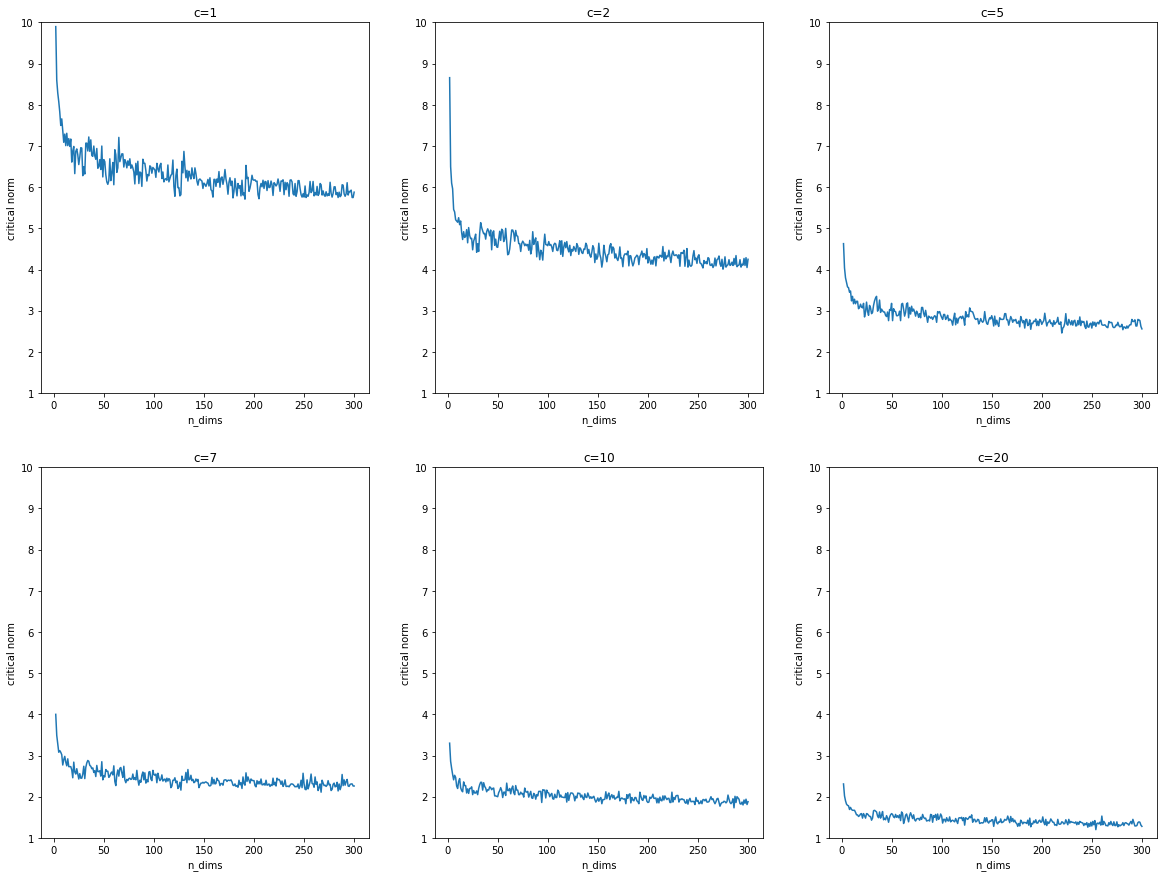

In [261]:
plt.figure(figsize=(20, 15))

plt.subplot(2, 3, 1)
plt.plot(dims, norms_1)
plt.title('c=1')
plt.ylabel('critical norm')
plt.ylim((1, 10))
plt.xlabel('n_dims')

plt.subplot(2, 3, 2)
plt.plot(dims, norms_2)
plt.title('c=2')
plt.ylabel('critical norm')
plt.ylim((1, 10))
plt.xlabel('n_dims')

plt.subplot(2, 3, 3)
plt.plot(dims, norms_5)
plt.title('c=5')
plt.ylabel('critical norm')
plt.ylim((1, 10))
plt.xlabel('n_dims')

plt.subplot(2, 3, 4)
plt.plot(dims, norms_7)
plt.title('c=7')
plt.ylabel('critical norm')
plt.ylim((1, 10))
plt.xlabel('n_dims')

plt.subplot(2, 3, 5)
plt.plot(dims, norms_10)
plt.title('c=10')
plt.ylabel('critical norm')
plt.ylim((1, 10))
plt.xlabel('n_dims')

plt.subplot(2, 3, 6)
plt.plot(dims, norms_20)
plt.title('c=20')
plt.ylabel('critical norm')
plt.ylim((1, 10))
plt.xlabel('n_dims')

plt.savefig('progress_report/critical_norm1.png')

In [262]:
cs = np.arange(1, 50, step=0.5)
norms_10 = np.zeros_like(cs)
norms_20 = np.zeros_like(cs)
norms_50 = np.zeros_like(cs)
norms_100 = np.zeros_like(cs)
norms_200 = np.zeros_like(cs)
norms_500 = np.zeros_like(cs)

for i, c in enumerate(cs):
    norms_10[i] = determine_critical_norm(10, c)
    norms_20[i] = determine_critical_norm(20, c)
    norms_50[i] = determine_critical_norm(50, c)
    norms_100[i] = determine_critical_norm(100, c)
    norms_200[i] = determine_critical_norm(200, c)
    norms_500[i] = determine_critical_norm(500, c)

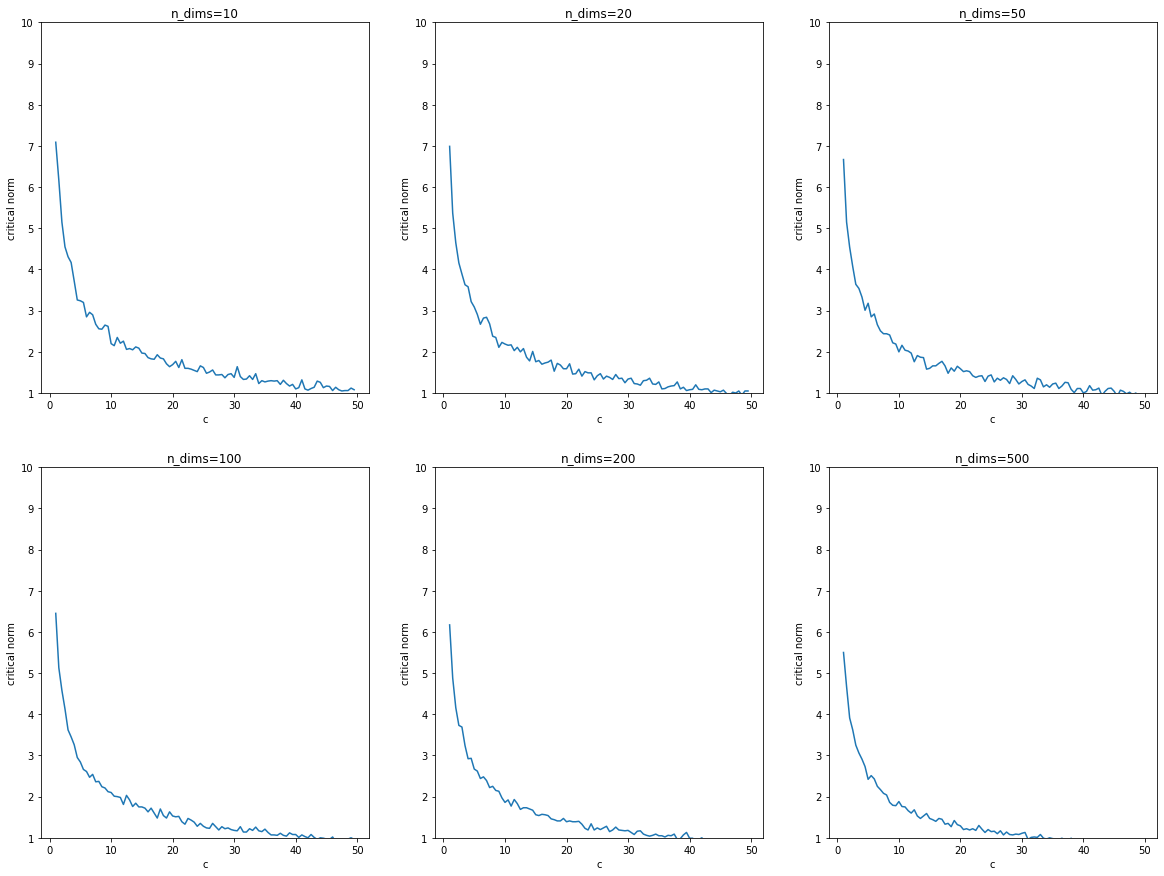

In [263]:
plt.figure(figsize=(20, 15))

plt.subplot(2, 3, 1)
plt.plot(cs, norms_10)
plt.title('n_dims=10')
plt.ylabel('critical norm')
plt.ylim((1, 10))
plt.xlabel('c')

plt.subplot(2, 3, 2)
plt.plot(cs, norms_20)
plt.title('n_dims=20')
plt.ylabel('critical norm')
plt.ylim((1, 10))
plt.xlabel('c')

plt.subplot(2, 3, 3)
plt.plot(cs, norms_50)
plt.title('n_dims=50')
plt.ylabel('critical norm')
plt.ylim((1, 10))
plt.xlabel('c')

plt.subplot(2, 3, 4)
plt.plot(cs, norms_100)
plt.title('n_dims=100')
plt.ylabel('critical norm')
plt.ylim((1, 10))
plt.xlabel('c')

plt.subplot(2, 3, 5)
plt.plot(cs, norms_200)
plt.title('n_dims=200')
plt.ylabel('critical norm')
plt.ylim((1, 10))
plt.xlabel('c')

plt.subplot(2, 3, 6)
plt.plot(cs, norms_500)
plt.title('n_dims=500')
plt.ylabel('critical norm')
plt.ylim((1, 10))
plt.xlabel('c')

plt.savefig('progress_report/critical_norm2.png')

## Working with initial similarity matrix

In [264]:
a = torch.tensor([[1, 1, 1], [1, 2, 3]]).float()
b = torch.tensor([[3, 4, 5], [1, 1, 1]]).float()

In [271]:
# should be [[6, 20], [1, 4]]

(a @ b.transpose(-1, -2)) - 2 * torch.einsum('i,j->ij', (a[..., : , 0], b[..., : , 0]))

tensor([[ 6.,  1.],
        [20.,  4.]])

In [270]:
torch.einsum('i,j->ij', (a[: , 0], b[: , 0]))

tensor([[3., 1.],
        [3., 1.]])